<a href="https://colab.research.google.com/github/deepakupman/GAN_MNIST/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST GAN

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from tqdm import tqdm_notebook

%matplotlib inline

In [0]:
# samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

# Visualize the data

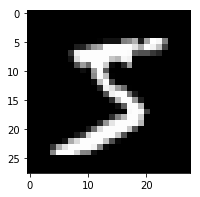

In [3]:
# obtain one batch of training images
images, _ = next(iter(train_loader))
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

# display image
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

**Discriminator:** The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:

**Generator:** The generator network will be almost exactly the same as the discriminator network, except that we're applying a tanh activation function to our output layer.

## Discriminator

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
    # hidden Linear Layers
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)
    
    # Dropout layer for regularization
    self.dropout = nn.Dropout(0.3)
    
  def forward(self, x):
    # flatten the input
    x = x.view(-1, 28*28)
    
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
    x = self.dropout(x)
    
    # output 
    return self.fc4(x)

## Generator

In [0]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
    # hidden linear layers
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
    self.fc4 = nn.Linear(hidden_dim*4, output_size)
    
    # dropout layer
    self.dropout = nn.Dropout(0.3)
    
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
    x = self.dropout(x)
    x = F.tanh(self.fc4(x))
    
    return x
    

## Model hyperparameters

In [0]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


## Discriminator and Generator Losses

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.
* The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.
* For the real images, we want `D(real_images) = 1`.
* Discriminator generalize better, if the labels are **reduced a bit from 1.0 to 0.9** parameter `smooth`will smooth the labels
* The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

> The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [0]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [0]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

In [10]:
# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the networks
D.train()
G.train()

for epoch in tqdm_notebook(range(num_epochs)):
  for r_image, _ in train_loader:
    batch_size = r_image.size(0)
    
    # rescale image into [-1, 1]
    r_image = r_image * 2 - 1
    
    # Train the Discriminator
    # train with real image
    r_out = D(r_image)
    r_loss = real_loss(r_out, smooth=True)
    
    # train with fake image
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    fake_image = G(z)
    
    # calculate discriminator loss for fake image
    f_out = D(fake_image)
    f_loss = fake_loss(f_out)
    
    # add both losses
    d_loss = r_loss + f_loss
    
    # backpropogation
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    #####################
    # Train the Generator
    
    # Generate latent vector
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    
    # Generate fake image from latent vector
    fake_image = G(z)
    
    # calculate discriminator loss for generated image
    d_image = D(fake_image)
    g_loss = real_loss(d_image)
    
    # perform backpropogation
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    
  print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
  
  # append d_loss and g_loss
  losses.append((d_loss.item(), g_loss.item()))
  
  # generate and save fake image after each epoch
  # turn on eval mode for G
  G.eval()
  samples.append(G(fixed_z))
  # turn on train mode for G
  G.train()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.5652 | g_loss: 0.7528
Epoch [    2/  100] | d_loss: 1.2626 | g_loss: 1.2594
Epoch [    3/  100] | d_loss: 1.1207 | g_loss: 1.9992
Epoch [    4/  100] | d_loss: 1.3709 | g_loss: 0.9263
Epoch [    5/  100] | d_loss: 1.1832 | g_loss: 1.1229
Epoch [    6/  100] | d_loss: 1.2780 | g_loss: 0.8995
Epoch [    7/  100] | d_loss: 1.1798 | g_loss: 1.3826
Epoch [    8/  100] | d_loss: 1.3219 | g_loss: 1.0399
Epoch [    9/  100] | d_loss: 1.8392 | g_loss: 1.0077
Epoch [   10/  100] | d_loss: 1.2257 | g_loss: 1.7275
Epoch [   11/  100] | d_loss: 1.0890 | g_loss: 1.2293
Epoch [   12/  100] | d_loss: 1.1823 | g_loss: 0.9654
Epoch [   13/  100] | d_loss: 1.1824 | g_loss: 0.6756
Epoch [   14/  100] | d_loss: 1.2440 | g_loss: 1.0782
Epoch [   15/  100] | d_loss: 1.4002 | g_loss: 0.9683
Epoch [   16/  100] | d_loss: 1.0439 | g_loss: 1.2721
Epoch [   17/  100] | d_loss: 1.2628 | g_loss: 1.2186
Epoch [   18/  100] | d_loss: 1.2118 | g_loss: 1.2586
Epoch [   19/  100] | d_loss

## Training loss

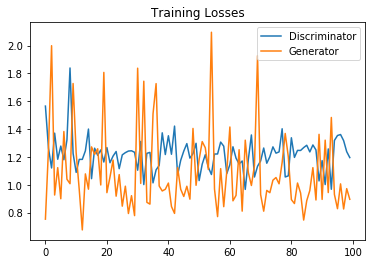

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator")
plt.plot(losses.T[1], label="Generator")
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

### View sample image saved after each epoch

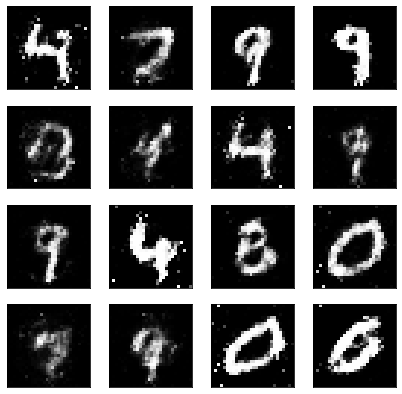

In [13]:
view_samples(-1, samples)

### Generate Image from random noise

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


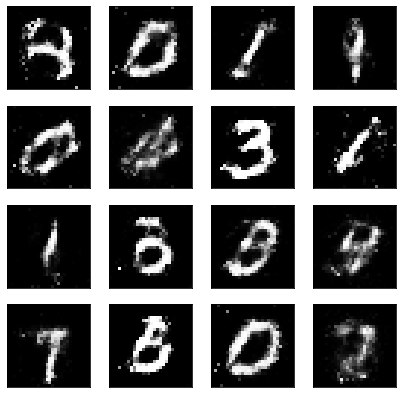

In [14]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])